Không sử dụng tập test, dùng tập train để train và test

## Import the libraries

In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import random_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split    

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

## Dataloader

In [2]:
class CMAPSSLoaderDataset(Dataset):
    def __init__(self, data, sequence_length):
        self.data = data
        self.sequence_length = sequence_length
        self.sequences = []
        self.targets = []
        
        grouped = data.groupby('ID Engine') 
        for _, group in grouped:        
            values = group.drop(['ID Engine', 'Cycle', 'Setting 1', 'Setting 2', 'Setting 3','Remaining RUL'], axis=1).values
            rul_values = group['Remaining RUL'].values
            
            for i in range(len(values) - sequence_length + 1):
                self.sequences.append(values[i:i + sequence_length]) 
                self.targets.append(rul_values[i + sequence_length - 1])
    
    def __len__(self):
        
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return (
            torch.tensor(self.sequences[idx], dtype=torch.float32),
            torch.tensor(self.targets[idx], dtype=torch.float32),
        )

## Transformer

In [3]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, dim_feedforward, dropout):
        super(TransformerModel, self).__init__()
        self.input_embedding = nn.Linear(input_dim, d_model)
        self.positional_encoding = nn.Parameter(torch.zeros(1, 5000, d_model))
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
        )
        self.fc_out = nn.Linear(d_model, 1)

    def forward(self, src):
        src_emb = self.input_embedding(src) + self.positional_encoding[:, :src.size(1), :]
        src_emb = src_emb.permute(1, 0, 2)
        transformer_out = self.transformer(src_emb, src_emb)
        output = self.fc_out(transformer_out[-1, :, :])
        return output.squeeze(-1)

## File paths

In [6]:
train_1 = "../data/train_FD002.txt"
test_1 = "../data/test_FD002.txt"
rul_1 = "../data/RUL_FD002.txt"

## Tính toán RUL cho train

In [7]:
index_names = ['ID Engine', 'Cycle']
setting_names = ['Setting 1', 'Setting 2', 'Setting 3']
sensor_names = ['Sensor {}'.format(i) for i in range(1, 22)]
column_names = index_names + setting_names + sensor_names

train = pd.read_csv(train_1, sep=' ', header=None)
train.drop([26, 27], axis=1, inplace=True)
train.columns = column_names

train['Remaining RUL'] = ''
train.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071,
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665,
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723,
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,...,2387.61,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701,
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,...,2028.00,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286,


In [8]:
max_cycle = train.groupby('ID Engine').count()

for idx in range(len(train)):
    train.loc[idx, 'Remaining RUL'] = max_cycle.loc[train.loc[idx, 'ID Engine'], 'Cycle']

train['Remaining RUL'] = train['Remaining RUL'] - train['Cycle']

In [9]:
train.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071,148
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665,147
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723,146
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,...,2387.61,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701,145
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,...,2028.00,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286,144


In [10]:
train.shape
# Có đầy đủ 27 features ban đầu

(53759, 27)

## Load RUL

In [11]:
rul = pd.read_csv(rul_1, sep=' ', header=None)
rul.drop(rul.columns[1], axis=1, inplace=True)
rul.columns = ['RUL']
rul.head()

,RUL
0,18
1,79
2,106
3,110
4,15


## Tính toán RUL cho test

In [12]:
test = pd.read_csv(test_1, sep=' ', header=None)
test.drop([26, 27], axis=1, inplace=True)
test.columns = column_names

test['Remaining RUL'] = ''
test.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,9.9987,0.2502,100.0,489.05,605.03,1497.17,1304.99,10.52,...,2388.18,8114.10,8.6476,0.03,369,2319,100.00,28.42,17.1551,
1,1,2,20.0026,0.7000,100.0,491.19,607.82,1481.20,1246.11,9.35,...,2388.12,8053.06,9.2405,0.02,364,2324,100.00,24.29,14.8039,
2,1,3,35.0045,0.8400,100.0,449.44,556.00,1359.08,1128.36,5.48,...,2387.75,8053.04,9.3472,0.02,333,2223,100.00,14.98,8.9125,
3,1,4,42.0066,0.8410,100.0,445.00,550.17,1349.69,1127.89,3.91,...,2387.72,8066.90,9.3961,0.02,332,2212,100.00,10.35,6.4181,
4,1,5,24.9985,0.6213,60.0,462.54,536.72,1253.18,1050.69,7.05,...,2028.05,7865.66,10.8682,0.02,305,1915,84.93,14.31,8.5740,


In [13]:
max_cycle_test = test.groupby('ID Engine').count()
max_cycle_test['Cycle'].head()

ID Engine
1    258
2     55
3    165
4     86
5    148
Name: Cycle, dtype: int64

In [14]:
rul.head()

,RUL
0,18
1,79
2,106
3,110
4,15


In [15]:
# Công thức tính toán RUL cho test có thể là:
# RUL cuối cùng (trong tập testtest) + Cycles đã trải qua - cột Cycle tương ứng
for idx in range(len(test)):
    test.loc[idx, 'Remaining RUL'] = rul.loc[test.loc[idx, 'ID Engine'] - 1, 'RUL'] + max_cycle_test.loc[test.loc[idx, 'ID Engine'], 'Cycle']

test['Remaining RUL'] = test['Remaining RUL'] - test['Cycle']

In [16]:
test.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,9.9987,0.2502,100.0,489.05,605.03,1497.17,1304.99,10.52,...,2388.18,8114.10,8.6476,0.03,369,2319,100.00,28.42,17.1551,275
1,1,2,20.0026,0.7000,100.0,491.19,607.82,1481.20,1246.11,9.35,...,2388.12,8053.06,9.2405,0.02,364,2324,100.00,24.29,14.8039,274
2,1,3,35.0045,0.8400,100.0,449.44,556.00,1359.08,1128.36,5.48,...,2387.75,8053.04,9.3472,0.02,333,2223,100.00,14.98,8.9125,273
3,1,4,42.0066,0.8410,100.0,445.00,550.17,1349.69,1127.89,3.91,...,2387.72,8066.90,9.3961,0.02,332,2212,100.00,10.35,6.4181,272
4,1,5,24.9985,0.6213,60.0,462.54,536.72,1253.18,1050.69,7.05,...,2028.05,7865.66,10.8682,0.02,305,1915,84.93,14.31,8.5740,271


In [17]:
# Trong tập test, động cơ có số lượng vòng đời được chạy ít nhất là ID Engine = 1 với số vòng đời trong tập test là 31 dòng
test.groupby('ID Engine').count().min()[0]

np.int64(21)

## Standard data (train and test)

In [18]:
# Bỏ đi các cột setting sẽ không chuẩn hóa
scaled_columns = train.columns[5:]
scaler = MinMaxScaler()
train[scaled_columns] = scaler.fit_transform(train[scaled_columns])
# test[scaled_columns] = scaler.fit_transform(test[scaled_columns])

In [19]:
train.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,34.9983,0.8400,100.0,0.060269,0.181576,0.311201,0.273095,0.146592,...,0.992394,0.476508,0.369947,0.0,0.322917,0.651163,1.0,0.156036,0.159082,0.392573
1,1,2,41.9982,0.8408,100.0,0.000000,0.131847,0.296600,0.245535,0.000000,...,0.992229,0.533013,0.381407,0.0,0.281250,0.627907,1.0,0.007888,0.014562,0.389920
2,1,3,24.9988,0.6218,60.0,0.238089,0.016332,0.035297,0.056997,0.293184,...,0.001157,0.039296,0.936731,0.0,0.062500,0.000000,0.0,0.133745,0.151414,0.387268
3,1,4,42.0077,0.8416,100.0,0.000000,0.128269,0.298795,0.246979,0.000000,...,0.992091,0.524349,0.372400,0.0,0.270833,0.627907,1.0,0.014060,0.026144,0.384615
4,1,5,25.0005,0.6203,60.0,0.238089,0.014130,0.037871,0.058152,0.293184,...,0.001075,0.030633,0.937537,0.0,0.062500,0.000000,0.0,0.135460,0.143240,0.381963


In [20]:
# test.head()

## Load data

In [21]:
sequence_length = 30
batch_size = 64
epochs = 50
input_dim = 21 # Frome sensor 1 to sensor 21

In [22]:
data_train = CMAPSSLoaderDataset(train, sequence_length=sequence_length)
# data_test = CMAPSSLoaderDataset(test, sequence_length=sequence_length)

train_data, validation_data = train_test_split(data_train, test_size=0.2, random_state=42)

train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=batch_size, shuffle=True)
# validation_loader = DataLoader(data_test, batch_size=batch_size, shuffle=True)

In [23]:
data_train.__len__()

46219

In [24]:
train_data.__len__()

36975

In [25]:
validation_data.__len__()

9244

In [26]:
train_loader.__len__()

723

In [27]:
validation_loader.__len__()

145

In [28]:
batch = next(iter(train_loader))
# print(batch)
seq, target = batch

# print(f'seq={seq}, shape={seq.shape}')
# print(f'target={target}, shape={target.shape}')

## Training model

In [29]:
def train(model, train_loader, validation_loader, epochs=epochs, verbose=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    for epoch in range(epochs):
        # Train
        model.train()
        train_loss = 0
        for batch in train_loader:
            seq, target = batch
            seq, target = seq.to(device), target.to(device)

            optimizer.zero_grad() # Reset gradient.
            output = model(seq) # Tính dự đoán từ mô hình.
            loss = criterion(output, target) # Tính giá trị mất mát giữa dự đoán và nhãn thật.
            loss.backward() # Tính gradient của mất mát.
            optimizer.step() # Cập nhật tham số mô hình dựa trên gradient.
            train_loss += loss.item() # Ghi nhận giá trị mất mát
        
        # Evaluate
        val_loss = 0
        model.eval()
        with torch.no_grad():
            for batch in validation_loader:
                seq, target = batch
                seq, target = seq.to(device), target.to(device)
                output = model(seq)
                loss = criterion(output, target)
                val_loss += loss.item()
        
        print(f"Epoch {epoch + 1}: Train Loss = {train_loss / len(train_loader)}, Val Loss = {val_loss / len(validation_loader)}")

In [30]:
model = TransformerModel(input_dim=input_dim, d_model=64, nhead=4, num_layers=2, dim_feedforward=256, dropout=0.1)
train(model=model, train_loader=train_loader, validation_loader=validation_loader, epochs=epochs)

Epoch 1: Train Loss = 0.036567153759496505, Val Loss = 0.016917292998525603
Epoch 2: Train Loss = 0.01886816245128876, Val Loss = 0.012825636469341558
Epoch 3: Train Loss = 0.015304849251208216, Val Loss = 0.01154086846408659
Epoch 4: Train Loss = 0.014074695125907494, Val Loss = 0.013657680417186227
Epoch 5: Train Loss = 0.01343411398294123, Val Loss = 0.013256173407466248
Epoch 6: Train Loss = 0.012808366991672279, Val Loss = 0.01183125141943837
Epoch 7: Train Loss = 0.012500681464185483, Val Loss = 0.011315959431873314
Epoch 8: Train Loss = 0.012454193627415419, Val Loss = 0.011067504509641179
Epoch 9: Train Loss = 0.012285980079091189, Val Loss = 0.011571789940754916
Epoch 10: Train Loss = 0.01232644975221462, Val Loss = 0.011836859824713962
Epoch 11: Train Loss = 0.012023791035748039, Val Loss = 0.01265797509715475
Epoch 12: Train Loss = 0.012090637016897174, Val Loss = 0.010926819962031882
Epoch 13: Train Loss = 0.01188466465100646, Val Loss = 0.010824059807406416
Epoch 14: Train

## Evaluate model

## Predict on a batch

In [31]:
len(validation_loader)

145

actual_predictions: [135.4327817   70.72499278 160.80164281 164.53638229 168.2810427
 115.51221615  67.75672059   2.77926622  28.27898129  57.87938933
 110.55700067  34.50163426 176.70599774   7.87544198  97.78507385
  27.65349956  67.68729097  87.66642705 147.03878075  18.62209287
   9.49695985  39.95340158 126.69241315  76.16331686  48.24576116
  15.10318407  47.60882205  91.2254774  136.65165102  15.14769059
  13.71939762 188.39867848  44.54908185  31.66416828  20.59709004
 131.14281872 120.49564391 148.83460298  32.04380095  49.84589511
 193.4898994   77.39518002 101.43182832 118.45733765 160.17048997
  96.03936183 175.94625488 135.68540013   1.70907594  19.28619936
  20.27662338  24.62898257  53.09928997   4.07620525 156.06495732
   6.72774096  97.25984907 124.38029835   6.41629077 172.45797679
  19.0214101  151.99495125 136.40125722  77.57554872]
actual_targets: [135.00000241  80.99999808 120.00000215 255.99999559 102.99999735
  90.99999826 101.00000405   7.99999986  31.99999945 

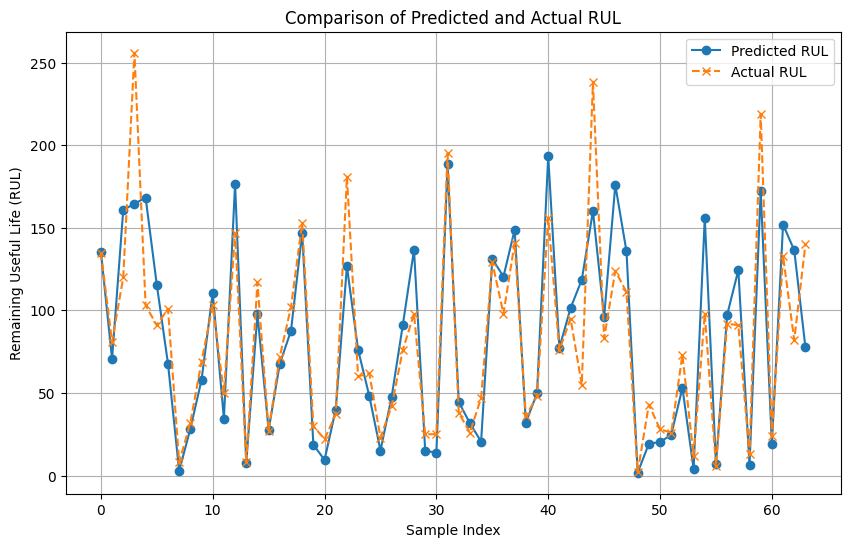

In [32]:
samples, targets = next(iter(validation_loader))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
samples, targets = samples.to(device), targets.to(device)

model.eval()
with torch.no_grad():
    predictions = model(samples)

# Đưa kết quả về CPU để xử lý
samples = samples.cpu()
targets = targets.cpu()
predictions = predictions.cpu()

# Đảo chuẩn hóa dữ liệu
rul_min = scaler.data_min_[-1]
rul_max = scaler.data_max_[-1]

# Đưa predictions và targets về dạng thực tế
actual_predictions = predictions.numpy() * (rul_max - rul_min) + rul_min
actual_targets = targets.numpy() * (rul_max - rul_min) + rul_min

print(f'actual_predictions: {actual_predictions}')
print(f'actual_targets: {actual_targets}')

# Vẽ biểu đồ so sánh dự đoán và giá trị thực tế
plt.figure(figsize=(10, 6))
plt.plot(range(len(actual_predictions)), actual_predictions, label="Predicted RUL", marker='o', linestyle='-')
plt.plot(range(len(actual_targets)), actual_targets, label="Actual RUL", marker='x', linestyle='--')
plt.title("Comparison of Predicted and Actual RUL")
plt.xlabel("Sample Index")
plt.ylabel("Remaining Useful Life (RUL)")
plt.legend()
plt.grid(True)
plt.show()

## Predict on a sample

In [33]:
samples.shape

torch.Size([64, 30, 21])

In [34]:
targets

tensor([0.3581, 0.2149, 0.3183, 0.6790, 0.2732, 0.2414, 0.2679, 0.0212, 0.0849,
        0.1830, 0.2732, 0.1326, 0.3899, 0.0212, 0.3103, 0.0716, 0.1910, 0.2706,
        0.4058, 0.0796, 0.0584, 0.0981, 0.4801, 0.1592, 0.1645, 0.0610, 0.1114,
        0.2016, 0.2599, 0.0663, 0.0663, 0.5172, 0.1008, 0.0690, 0.1247, 0.3422,
        0.2599, 0.3740, 0.0955, 0.1273, 0.4138, 0.2016, 0.2520, 0.1459, 0.6313,
        0.2202, 0.3289, 0.2944, 0.0053, 0.1141, 0.0743, 0.0690, 0.1936, 0.0318,
        0.2599, 0.0159, 0.2440, 0.2414, 0.0345, 0.5809, 0.0637, 0.3528, 0.2175,
        0.3714])

In [35]:
targets.shape

torch.Size([64])

In [36]:
idx = 0
sample = samples[idx].unsqueeze(0)
target = targets[idx].unsqueeze(0)

print(sample.shape)
print(target)

torch.Size([1, 30, 21])
tensor([0.3581])


In [37]:
model.eval()
with torch.no_grad():
    prediction = model(sample)

sample = sample.cpu()
target = target.cpu()
prediction = prediction.cpu()

print(f'Prediction: {prediction}')
print(f'Target: {target}')

rul_min = scaler.data_min_[-1]
rul_max = scaler.data_max_[-1]

prediction = predictions.numpy() * (rul_max - rul_min) + rul_min
actual_prediction = sum(prediction)/len(prediction)
actual_target = targets.numpy() * (rul_max - rul_min) + rul_min

# print(f'Giá trị RUL thực tế {actual_target}')
print(f'Giá trị RUL thực tế {actual_target[-1]}')
print(f'Giá trị RUL dự đoán {actual_prediction}')

Prediction: tensor([0.3592])
Target: tensor([0.3581])
Giá trị RUL thực tế 140.00000250339508
Giá trị RUL dự đoán 82.27576438104734


In [38]:
prediction

array([135.4327817 ,  70.72499278, 160.80164281, 164.53638229,
       168.2810427 , 115.51221615,  67.75672059,   2.77926622,
        28.27898129,  57.87938933, 110.55700067,  34.50163426,
       176.70599774,   7.87544198,  97.78507385,  27.65349956,
        67.68729097,  87.66642705, 147.03878075,  18.62209287,
         9.49695985,  39.95340158, 126.69241315,  76.16331686,
        48.24576116,  15.10318407,  47.60882205,  91.2254774 ,
       136.65165102,  15.14769059,  13.71939762, 188.39867848,
        44.54908185,  31.66416828,  20.59709004, 131.14281872,
       120.49564391, 148.83460298,  32.04380095,  49.84589511,
       193.4898994 ,  77.39518002, 101.43182832, 118.45733765,
       160.17048997,  96.03936183, 175.94625488, 135.68540013,
         1.70907594,  19.28619936,  20.27662338,  24.62898257,
        53.09928997,   4.07620525, 156.06495732,   6.72774096,
        97.25984907, 124.38029835,   6.41629077, 172.45797679,
        19.0214101 , 151.99495125, 136.40125722,  77.57

In [39]:
target

tensor([0.3581])